
<font color="#483D8B">
<h1 align="center"> Random Forrests, Stepwise selection, PCA, and Feature Elimination</h1>
<h3 align="center"> Evan Ditter </h3>
<h3 align="center">March 11, 2019</h3>
</font>

---------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Stepwise selection
import statsmodels.api as sm

# For Principal component analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For Recursive feature elimination
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

# For Feature Importance
from sklearn.ensemble import RandomForestClassifier

# For logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

## Overview

In this lab I will analyze the question: **Can you predict who would be interested in buying a caravan insurance policy and give an explanation.** This is the same question as used in the last lab, however, this lab will determine this through a different set of methods.

These methods are as follows:

* Feature importance through random forests
* Stepwise selection based on p-values
* Principal component analysis
* Recursive feature elimination

These methods of feature selection will then be used by a logistic regressin model that will generate a classification model to be compared and contrasted with the other models.

**References and Sources:**

* Data sourced from:https://www.kaggle.com/uciml/caravan-insurance-challenge/version/1 P. van der Putten and M. van Someren (eds) . CoIL Challenge 2000: The Insurance Company Case. Published by Sentient Machine Research, Amsterdam. Also a Leiden Institute of Advanced Computer Science Technical Report 2000-09. June 22, 2000.
* Definitions sourced in part from class slides created by Katherine Splett and hosted through canvas at https://canvas.umn.edu/courses/108778.
* Code referenced from class example 6.2, created by Katherine Splett, found at https://docs.google.com/document/d/1Gfs39-jtahQ3a5eR0zAo3CnftQL_JQLaN7FBg-vrORU/edit
* Code referenced: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
* Code sourced from https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7
* Code sourced from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Data

**Definitions:**

* **Stepwise selection** - A method by which explanitory variables are chosen for a model in relation to a response variable. This is done algorithmically and will result in a variable being added or removed from a model.
* **Principle component analysis** - Linear mapping of the data to a lower-dimensional space so the explained variance in the low-dimensional representation is maximized.
* **Recursive feature elimination** - A greedy optimization algorithm that iteratively creates models and remembers the best or the worst performing feature at each iteration, later ranking these features for addition or elimination.
* **Random forest classification** - An ensemble learning method by which several classification trees are generated based on a random selection of explanitory variables in relation to a response variable.

As stated at the data source: "this data set used in the CoIL 2000 Challenge contains information on customers of an insurance company. The data consists of 86 variables and includes product usage data and socio-demographic data derived from zip area codes. The data was collected to answer the following question: Can you predict who would be interested in buying a caravan insurance policy and give an explanation why?"(P. van der Putten et al). As stated in the references, one can download the utilized data set from https://www.kaggle.com/uciml/caravan-insurance-challenge/version/1. The meaning of columns can also be taken from this link.

The most important takeaway while looking at data is that the chosen response variable: CARAVAN has a value of 1 if the given case models a customer who purchased caravan insurance while a value of 0 represents no purchase of caravan insuarance.

The dataset contains a far greater number of cases where CARAVAN has a value of 0 than 1 as will be further demonstrated in Exploratory Data Analysis.

Test and training data are seperated by the value in the ORIGIN column.

In [2]:
df = pd.read_csv("caravan-insurance-challenge.csv")
d_tr = df[df["ORIGIN"] == "train"]
d_ts = df[df["ORIGIN"] == "test"]

## Exploratory Data Analysis

In [3]:
df_tr = d_tr.drop(["ORIGIN"], axis = 1)
df_tr.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [4]:
df_ts = d_ts.drop(["ORIGIN"], axis = 1)
df_ts.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
5822,33,1,4,2,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,0
5823,6,1,3,2,2,0,5,0,4,5,...,0,0,0,1,0,0,0,0,0,1
5824,39,1,3,3,9,1,4,2,3,5,...,0,0,0,1,0,0,0,0,0,0
5825,9,1,2,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
5826,31,1,2,4,7,0,2,0,7,9,...,0,0,0,1,0,0,0,0,0,0


The data set, seen above consists of 9821 observations from a training and test set. Observations can be differentiated by their value in the ORIGIN column. All of the various columns have meanings that can be looked up at the aforementioned link above. The last column, which reads 1 or 0 where 1 indicates purchased insurances and 0 indicates no purchase of insurance. Only the training data will be used for model creation and fitness will be tested against the test data. For the purposes of this lab the "CARAVAN" column will be used as a response variable.

Not purchased 9236
Purchased: 586


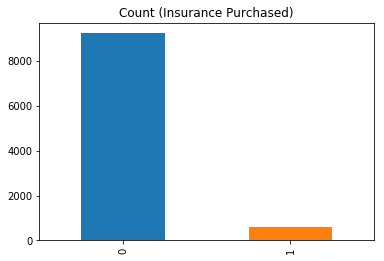

In [5]:
df_c = df.CARAVAN.value_counts()
print('Not purchased', df_c[0])
print('Purchased:', df_c[1])
df_c.plot(kind='bar', title='Count (Insurance Purchased)');

As one can see, this is a very imbalanced dataset with less than 10% of responses indicating a purchased insurance plan. This is also true of testing and training data as shown in the figures below.

**Training**

Not purchased 5474
Purchased: 348


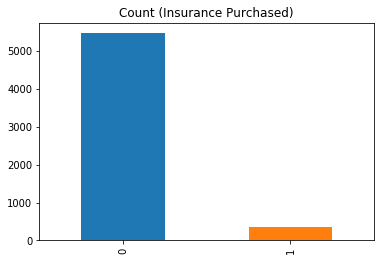

In [6]:
df_tr_c = df_tr.CARAVAN.value_counts()
print('Not purchased', df_tr_c[0])
print('Purchased:', df_tr_c[1])
df_tr_c.plot(kind='bar', title='Count (Insurance Purchased)');

**Test**

Not purchased 3762
Purchased: 238


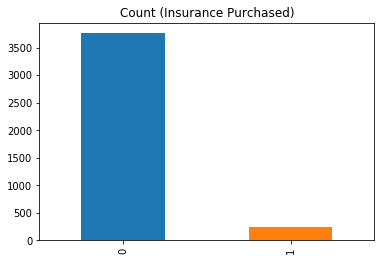

In [7]:
df_ts_c = df_ts.CARAVAN.value_counts()
print('Not purchased', df_ts_c[0])
print('Purchased:', df_ts_c[1])
df_ts_c.plot(kind='bar', title='Count (Insurance Purchased)');

In [8]:
y = df_tr["CARAVAN"]
X = df_tr.drop(["CARAVAN"], axis = 1)

y_tst = df_ts["CARAVAN"]
X_tst = df_ts.drop(["CARAVAN"], axis = 1)

### Stepwise selection by p-value

In [9]:
## Code written by Katherine Splett
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add  PPERSAUT                       with p-value 5.28958e-31
Add  APLEZIER                       with p-value 5.67554e-15
Add  MKOOPKLA                       with p-value 1.8286e-12
Add  PWAPART                        with p-value 8.03918e-09
Add  MOPLLAAG                       with p-value 9.84051e-05
Add  MRELGE                         with p-value 0.000261024
Add  PBRAND                         with p-value 0.00113092
Add  ABYSTAND                       with p-value 0.00153451
Add  MBERBOER                       with p-value 0.00340782
Add  AFIETS                         with p-value 0.00620814
resulting features:
['PPERSAUT', 'APLEZIER', 'MKOOPKLA', 'PWAPART', 'MOPLLAAG', 'MRELGE', 'PBRAND', 'ABYSTAND', 'MBERBOER', 'AFIETS']


Using this stepwise selection function, features with the smallest, and therefore most significant features are chosen using a critical threshold of 0.01. The human meaning od these features can be found at the source link. I then reduce the dataframe to only include these features.

In [10]:
df_ss = df_tr[result]
df_ss_tst = df_ts[result]
df_ss.head()

,PPERSAUT,APLEZIER,MKOOPKLA,PWAPART,MOPLLAAG,MRELGE,PBRAND,ABYSTAND,MBERBOER,AFIETS
0,6,0,3,0,7,7,5,0,1,0
1,0,0,4,2,4,6,2,0,0,0
2,6,0,4,2,4,3,2,0,0,0
3,6,0,4,0,2,5,2,0,0,0
4,0,0,3,0,0,7,6,0,4,0


### Principal component analysis

In [11]:
# Number of components to be selected (the selected value 3 is arbitrary )
pca_num = 85

# Standardize data
X_pca = StandardScaler().fit_transform(X)
X_pca_tst = StandardScaler().fit_transform(X_tst)

# Perform PCA
pca = PCA(n_components = pca_num)
pc = pca.fit_transform(X_pca)
pc_tst = pca.fit_transform(X_pca_tst)

# Create column headers for principal components
col = []
for i in range(1, pca_num + 1):
    col += ["principal component " + str(i)]

# df creation
df_pca = pd.DataFrame(data = pc, columns = col)
df_pca_tst = pd.DataFrame(data = pc_tst, columns = col)

df_pca.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 76,principal component 77,principal component 78,principal component 79,principal component 80,principal component 81,principal component 82,principal component 83,principal component 84,principal component 85
0,0.550707,3.410686,-0.804213,-1.029871,-0.083947,0.258962,-0.195425,-0.094469,0.133187,-0.623486,...,0.023370,-0.120863,0.003183,0.029652,-0.047551,0.197733,-0.007919,0.044500,0.009593,9.254238e-07
1,-0.576122,0.025922,-0.404458,-2.059648,0.863661,-0.604844,-1.949084,-0.633307,-0.236770,1.223139,...,0.403778,0.205379,-0.108092,0.653086,1.120670,0.382806,-0.002846,-0.137838,0.006787,-6.488777e-04
2,2.871990,-1.903902,0.138243,-2.445421,2.777318,-2.679845,-1.821069,0.834435,-0.370453,-0.184450,...,-0.060896,-0.025697,-0.022811,-0.251001,0.089428,-0.082904,-0.000794,-0.099142,-0.003025,3.632410e-03
3,-1.554568,-1.175751,-0.575601,-0.362423,1.614971,-1.457542,0.337027,-0.425847,0.656148,-0.872591,...,-0.058928,-0.289388,-0.016775,0.010497,0.081730,-0.149946,-0.006637,0.176736,-0.008019,2.384704e-03
4,-4.346824,-0.197035,0.976670,1.252781,-3.041040,1.343599,-0.377780,-1.154248,0.539118,0.911733,...,0.052052,0.177183,-0.001257,0.051689,-0.013661,-0.063566,0.010725,0.110799,0.011995,8.895207e-03


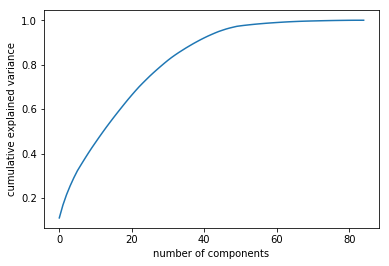

In [12]:
pca = PCA().fit(X_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

The original training data is splin into principal components as seen above which are standardized and made independent of eachother for model creation. A sample of this dataframe can be seen above. The number of principal components can be changed depending on the user's needs. Based on the plot of component number versus the explained variance, it would seem that around 50 components is the ideal number to explain the variance without overfitting.

### Recursive feature elimination

In [13]:
# Code sourced from https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7
# create the RFE model for the svm classifier 
# and select attributes
num = 50 
m_ref = LogisticRegression()
rfe = RFE(m_ref, num)
rfe = rfe.fit(X, y)

# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)
f = rfe.get_support(1) #the most important features
df_rfe = df_tr[df_tr.columns[f]] # final features`
df_rfe_tst = df_ts[df_ts.columns[f]]

df_rfe.head()

[False  True False  True False False False False False  True False  True
 False False False False False  True False False  True False False False
 False False False False False  True  True  True  True False  True  True
  True  True  True  True  True  True False  True  True  True  True False
 False  True  True  True  True False  True  True  True  True  True False
  True  True  True False  True  True False False  True False False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True]
[ 8  1 22  1  7  6 31 32 21  1 19  1 18 16 17 20 11  1 15 25  1 13 26 14
 29 35 30 12 34  1  1  1  1  2  1  1  1  1  1  1  1  1  9  1  1  1  1 27
  4  1  1  1  1 33  1  1  1  1  1  5  1  1  1 36  1  1 23 28  1  3 10  1
  1  1  1  1 24  1  1  1  1  1  1  1  1]


,MAANTHUI,MGEMLEEF,MRELGE,MRELOV,MOPLLAAG,MBERBOER,MHHUUR,MHKOOP,MAUT1,MAUT2,...,ABROM,ALEVEN,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,1,2,7,2,7,1,1,8,8,0,...,0,0,0,0,1,0,0,0,0,0
1,1,2,6,2,4,0,2,7,7,1,...,0,0,0,0,1,0,0,0,0,0
2,1,2,3,4,4,0,7,2,7,0,...,0,0,0,0,1,0,0,0,0,0
3,1,3,5,2,2,0,5,4,9,0,...,0,0,0,0,1,0,0,0,0,0
4,1,2,7,2,0,4,4,5,6,2,...,0,0,0,0,1,0,0,0,0,0


As seen above, the most impactful attributes are selected after all other features are eliminated through RFE. The rankings are shown above as is a sample of the dataframe.

### Feature importance

In [14]:
rnd_clf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)
rfc_col = []
i_thresh = .02
for name, importance in zip(X.columns.values, rnd_clf.feature_importances_):
    if importance > i_thresh:
        rfc_col += [name]
        print(name, "=", importance)

MOSTYPE = 0.032656278286176475
MOSHOOFD = 0.02782808026973147
MOPLMIDD = 0.02013434039990449
MOPLLAAG = 0.02305552507917722
MKOOPKLA = 0.021343676450385884
PWAPART = 0.0326137803119475
PPERSAUT = 0.04586114432317607
PBRAND = 0.05488490672191408
AWAPART = 0.021480582431873722
APERSAUT = 0.04484186568764337
ABRAND = 0.023491309907194717


From this I see the relative importance of each feature above some threshold set by a user. The full list is very long and hard to digest so it will not be included in this report.

In [15]:
df_rfc = df_tr[rfc_col]
df_rfc_tst = df_ts[rfc_col]
df_rfc.head()

,MOSTYPE,MOSHOOFD,MOPLMIDD,MOPLLAAG,MKOOPKLA,PWAPART,PPERSAUT,PBRAND,AWAPART,APERSAUT,ABRAND
0,33,8,2,7,3,0,6,5,0,1,1
1,37,8,5,4,4,2,0,2,2,0,1
2,37,8,5,4,4,2,6,2,1,1,1
3,9,3,4,2,4,0,6,2,0,1,1
4,40,10,4,0,3,0,0,6,0,0,1


This used a randomforest model to chose features with relative importance greater than the set threshold of .02.

## Models

Now that all of the important features have been selected for modeling, I can create the logistic regression models for each of these feature sets. First a control must be done against which I can judge the other models with the full dataset. This can be found below.

In [16]:
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred = logreg.predict(X_tst)

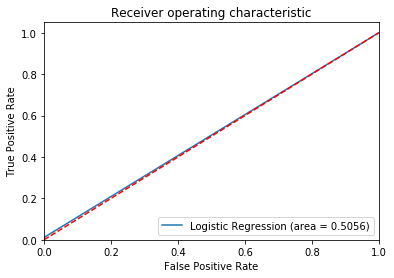

In [17]:
fpr, tpr, thresholds = roc_curve(y_tst, y_pred);fpr, tpr, thresholds
logit_roc_auc = roc_auc_score(y_tst, y_pred);logit_roc_auc

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

On this ROC ideally area under curve is 1.0 where .5 indicates no predictive power. In the case of this model, there is almost no predictive power.

### Stepwise selection by p-value

In [18]:
logreg = LogisticRegression()
logreg.fit(df_ss, y)
y_pred = logreg.predict(df_ss_tst)

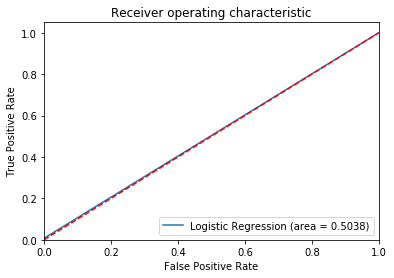

In [19]:
logit_roc_auc = roc_auc_score(y_tst, y_pred)
fpr, tpr, thresholds = roc_curve(y_tst, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Stepwise selection actually results in a lower area under curve than the control, sugesting that the predictive power of the model created using stepwise selection on features is worse than that of a comprehensive model with all data.

### Recursive feature elimination

In [20]:
logreg = LogisticRegression()
logreg.fit(df_rfe, y)
y_pred = logreg.predict(df_rfe_tst)

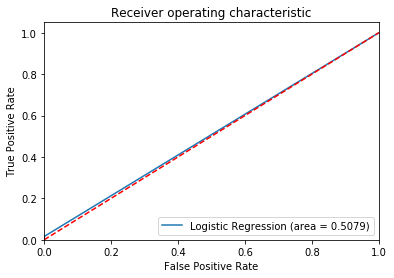

In [21]:
logit_roc_auc = roc_auc_score(y_tst, y_pred)
fpr, tpr, thresholds = roc_curve(y_tst, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This ROC has a greater AUC than both the previous models, indicating that recursive feature elimination correlates to greater predictive power than the previous two methods.

### Feature importance

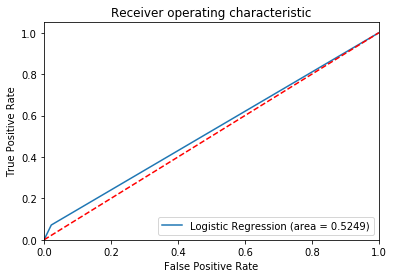

In [22]:
model = RandomForestClassifier(n_estimators = 10)
model.fit(df_rfc, y)
y_pred = model.predict(df_rfc_tst)

logit_roc_auc = roc_auc_score(y_tst, y_pred)
fpr, tpr, thresholds = roc_curve(y_tst, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The final method, feature importance based on a random forest classifier has the greatest predicitive power of any of the models, still barely above totally unpredictive. The auc for this indicates that feature importance correlates to a stronger predictive model than the previous models.

## Conclusions

Based on the data and models above, it would seem that the most effective way to eliminate features of the given data is RandomForest Feature Importance. Even with an arbitrary value used as a cutoff for importance (as opposed to an algorithmic value), this method returned the greatest AUC. This was still very far from a perfect predictor, however, as an AUC of .5349 is only marginally better than .5 - indicating no predictive power at all.

This perhaps could be improved in the future by combining this with methods of balancing the data such as SMOTE of Bagging. On top of this an algorithm could be, and probably has been, devised to find the exact optimal number of elements for each of the above methods to maximise predictive power. By adding these potential boosts to our models, perhaps a more perfect model predictor could be devised to predict if a person should be targeted with caravan insurance.